
---
# Customer Asset Financing Risk Prediction
---

## Executive Summary

This notebook aimed to predict customer asset financing risk by evaluating customer data, including demographics, credit history, and income. The process involves:

- Data preprocessing,
- Exploratory data analysis (EDA),
- Feature engineering, and
- Development of several machine learning models.

Key findings from EDA highlighted significant missingness in certain features, a notable class imbalance where approximately 8% of customers defaulted on their loans , and the strong predictive power of external data sources (`EXT_SOURCE_2/3`).

Feature engineering addressed missing values by dropping columns with over 50% missing data (e.g., `OWN_CAR_AGE`, `EXT_SOURCE_1` , imputing remaining numerical values with the mean, and filling categorical missing values with 'Unknown'New features like `CREDIT_INCOME_RATIO` and `EMPLOYMENT_AGE_RATIO` were created to enhance the predictive signal. Categorical variables were handled using a hybrid approach: one-hot encoding for low-cardinality features and label encoding for high-cardinality ones, optimizing for model input quality.

Four classification models:
- Logistic Regression,
- Random Forest,
- XGBoost, and
- CatBoost
All models trained and evaluated using stratified K-Fold cross-validation, with ROC AUC as the primary metric. CatBoost emerged as the top-performing model with an ROC AUC of approximately 0.7505, closely followed by XGBoost. This indicates a reasonable ability to distinguish between loan repayers and defaulters.

Model interpretability using SHAP values revealed critical features influencing predictions, such as `EXT_SOURCE_3`, `EXT_SOURCE_2`, `CODE_GENDER_M`, `AMT_GOODS_PRICE`, and `DAYS_BIRTH`. These insights provide actionable recommendations for improving loan funding decisions.

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import shap
import xgboost as xgb
import catboost as cat
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

---
>## 1. Exploratory Data Analysis (EDA)
---

The initial dataset, `application_train.csv`, contained 307,511 entries and 122 columns. It encompassed a variety of customer information, including demographics, loan details, and financial indicators.

>### Dataset Structure and Key Statistics

A preliminary look at the data revealed columns such as `SK_ID_CURR`, `TARGET` (the binary target variable for default), `NAME_CONTRACT_TYPE`, `CODE_GENDER`, and `FLAG_OWN_CAR`. Descriptive statistics for numerical columns showed ranges and distributions for features like `AMT_INCOME_TOTAL`, `AMT_CREDIT`, and `DAYS_BIRTH`.

>### Missing Values, Outliers, and Class Distribution

**Missing Values:**
A significant challenge was the presence of missing values. Features with more than 50% missing values were dropped.
* `OWN_CAR_AGE`, `EXT_SOURCE_1`, `APARTMENTS_AVG`, and other `'APARTMENTS_'`, `'BASEMENTAREAS_'`, `'YEARS_'`, `'NONLIVINGAPARTMENTS_'`, `'COMMONAREA_'`, `'FONDKAPREMONT_MODE'`, `'FLOORSMAX_'`, `'ELEVATORS_'`, `'ENTRANCES_'`, `'BUILDING_'`, `'LIVINGAREA_'`, `'HOUSETYPE_MODE'`, `'TOTALAREA_MODE'`, `'WALLSMATERIAL_MODE'`, `'EMERGENCYSTATE_MODE'`, `'OBS_30_CNT_SOCIAL_CIRCLE'`, `'DEF_30_CNT_SOCIAL_CIRCLE'`, `'OBS_60_CNT_SOCIAL_CIRCLE'`, `'DEF_60_CNT_SOCIAL_CIRCLE'`, `'AMT_REQ_CREDIT_BUREAU_HOUR'`, `'AMT_REQ_CREDIT_BUREAU_DAY'`, `'AMT_REQ_CREDIT_BUREAU_WEEK'`, `'AMT_REQ_CREDIT_BUREAU_MON'`, `'AMT_REQ_CREDIT_BUREAU_QRT'`, `'AMT_REQ_CREDIT_BUREAU_YEAR'` were among the columns with high missingnessThe visual structure of missingness was also explored using a missingness matrix.

In [6]:
df = pd.read_csv("data/application_train.csv")
print("Shape:", df.shape)

pd.set_option('display.max_columns', None)
df.head()


Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511.0,278180.518577,102790.175348,100002.0,189145.5,278202.0,367142.5,456255.0
TARGET,307511.0,0.080729,0.272419,0.0,0.0,0.0,0.0,1.0
CNT_CHILDREN,307511.0,0.417052,0.722121,0.0,0.0,0.0,1.0,19.0
AMT_INCOME_TOTAL,307511.0,168797.919297,237123.146279,25650.0,112500.0,147150.0,202500.0,117000000.0
AMT_CREDIT,307511.0,599025.999706,402490.776996,45000.0,270000.0,513531.0,808650.0,4050000.0
...,...,...,...,...,...,...,...,...
AMT_REQ_CREDIT_BUREAU_DAY,265992.0,0.007000,0.110757,0.0,0.0,0.0,0.0,9.0
AMT_REQ_CREDIT_BUREAU_WEEK,265992.0,0.034362,0.204685,0.0,0.0,0.0,0.0,8.0
AMT_REQ_CREDIT_BUREAU_MON,265992.0,0.267395,0.916002,0.0,0.0,0.0,0.0,27.0
AMT_REQ_CREDIT_BUREAU_QRT,265992.0,0.265474,0.794056,0.0,0.0,0.0,0.0,261.0


In [15]:
def corr(data, cmap="viridis"):
    plt.figure(figsize=(30, 25))
    sns.heatmap(data, annot=True, cmap=cmap, fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Features', color="brown", size=20)
    plt.show()


def show_distribution(data, col):
    data = data.copy()
    col = str(col)

    mean = round(data[col].mean(), 4)
    std = round(data[col].std(), 4)
    mode = round(data[col].mode()[0], 4)
    var = round(np.sqrt(data[col].std()), 4)
    print("The mathemiocal distribution of the data are presented as follows: ")
    print(f"Mean:{mean} \nMode:{mode} \nStandard Deviation:{std} \nVariance:{var}")

    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    sns.histplot(data[col], ax=ax[0], binwidth=1, color="black")
    ax[0].axvline(mean, linewidth=2, linestyle="--", color="red", label="mean")
    ax[0].axvline(mode, linewidth=1, linestyle="--", color="orange", label="mode")
    ax[0].axvline(std, linewidth=1, linestyle="--", color="blue", label="standard deviation")
    ax[0].axvline(var, linewidth=1, linestyle="--", color="yellow", label="standard deviation")
    ax[0].set_title(f"Distribution Plot for {col}", color="brown")

    sns.boxplot(y=data[col], ax=ax[1], width=0.5, color="black")
    ax[1].axhline(mean, linewidth=2, linestyle="--", color="red", label="mean")
    ax[1].axhline(mode, linewidth=1, linestyle="--", color="orange", label="mode")
    ax[1].axhline(std, linewidth=1, linestyle="--", color="blue", label="standard deviation")
    ax[1].axhline(var, linewidth=1, linestyle="--", color="yellow", label="standard deviation")
    ax[1].set_title(f"Boxplot for {col}", color="brown")
    ax[1].legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
    plt.show()


def show_unique_values(df, col):
    if df[col].nunique() < 5:
        plt.figure(figsize=(5,3))
        print(f"{'-' * 120}")
        print(f"{col}")
        print(f"{'-' * 120}")
        df[col].value_counts(ascending=True).plot(kind="bar", color="black")
        plt.xlabel(f"{col}")
        plt.xticks(rotation=0)
        plt.show()

    elif df[col].nunique() < 15:
        plt.figure(figsize=(10,8))
        print(f"{'-' * 120}")
        print(f"{col}")
        print(f"{'-' * 120}")
        df[col].value_counts(ascending=True).plot(kind="barh", color="black")
        plt.xlabel(f"{col}")
        plt.show()

    else:
        plt.figure(figsize=(10,4))
        print(f"{'-' * 120}")
        print(f"{col}")
        print(f"{'-' * 120}")
        df[col].value_counts().head(10).plot(kind="barh", color="black")
        plt.xlabel(f"{col}")
        plt.show()

In [16]:
df_corr = df[[col for col in df.columns if df[col].dtype==float]].corr()
df_corr

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
AMT_INCOME_TOTAL,1.000000,0.156870,0.191657,0.159610,0.074796,0.027805,-0.117273,0.016342,0.026232,0.060925,-0.030229,0.034501,0.017303,0.005658,0.042334,0.089616,0.045053,0.005394,0.060171,0.139860,-0.001598,0.106920,0.039976,0.029520,0.074604,0.029994,0.012821,0.005284,0.037299,0.075625,0.041032,0.002027,0.057675,0.131800,-0.003674,0.092991,0.034915,0.025020,0.061778,0.033798,0.016381,0.005639,0.042004,0.087918,0.044160,0.004787,0.059682,0.138489,-0.001892,0.104914,0.039261,0.028098,0.070844,0.041985,-0.013099,-0.013244,-0.013015,-0.013135,-0.018585,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690
AMT_CREDIT,0.156870,1.000000,0.770138,0.986968,0.099738,0.009621,-0.094191,0.063160,0.168429,0.131228,0.043516,0.060439,0.039226,0.006249,0.035875,0.049537,0.080635,0.014929,0.103296,0.078832,0.006218,0.058788,0.072146,0.014362,0.037885,0.053072,0.031213,0.004804,0.033478,0.042341,0.074740,0.009361,0.100418,0.075485,0.002532,0.051208,0.064142,0.011106,0.032390,0.058682,0.037281,0.005765,0.035589,0.048565,0.079094,0.013692,0.102770,0.078375,0.005415,0.057058,0.070860,0.013402,0.035829,0.072818,0.000190,-0.021229,0.000239,-0.023767,-0.073701,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448
AMT_ANNUITY,0.191657,0.770138,1.000000,0.775109,0.118429,0.038514,-0.097057,0.075539,0.119398,0.125804,0.030752,0.076213,0.044507,0.013298,0.034195,0.057628,0.101439,0.014745,0.130174,0.099812,0.008611,0.075293,0.089659,0.021306,0.049593,0.066401,0.034443,0.012555,0.030932,0.049074,0.093131,0.007362,0.126302,0.094457,0.003621,0.065606,0.079426,0.016754,0.041418,0.073987,0.042452,0.012940,0.033713,0.056865,0.099559,0.013276,0.129179,0.098642,0.007711,0.073049,0.088134,0.020473,0.047009,0.090415,-0.011987,-0.022833,-0.011731,-0.024001,-0.063747,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320
AMT_GOODS_PRICE,0.159610,0.986968,0.775109,1.000000,0.103520,0.011565,-0.103733,0.061185,0.175502,0.139367,0.047717,0.064918,0.043982,0.007245,0.041937,0.050507,0.083736,0.018764,0.108512,0.081411,0.013297,0.061850,0.077307,0.015424,0.041912,0.057523,0.035811,0.005799,0.039410,0.043086,0.077978,0.013335,0.105532,0.077770,0.009379,0.053813,0.069324,0.011866,0.036403,0.063187,0.041980,0.006839,0.041583,0.049519,0.082266,0.017585,0.107936,0.080863,0.012550,0.060104,0.076028,0.014381,0.039874,0.077527,0.000328,-0.022244,0.000347,-0.024506,-0.076313,-0.003237,0.004677,-0.001007,0.056422,0.016432,-0.050998
REGION_POPULATION_RELATIVE,0.074796,0.099738,0.118429,0.103520,1.000000,-0.053820,-0.081429,-0.024209,0.099997,0.198924,-0.006001,0.205942,0.098423,-0.006683,-0.056566,0.164806,0.280685,0.036840,0.322652,0.294349,-0.051160,0.194452,0.213491,0.024293,0.074816,0.175029,0.065779,-0.006837,-0.063779,0.130931,0.251539,0.015983,0.303992,0.275656,-0.060558,0.163156,0.18

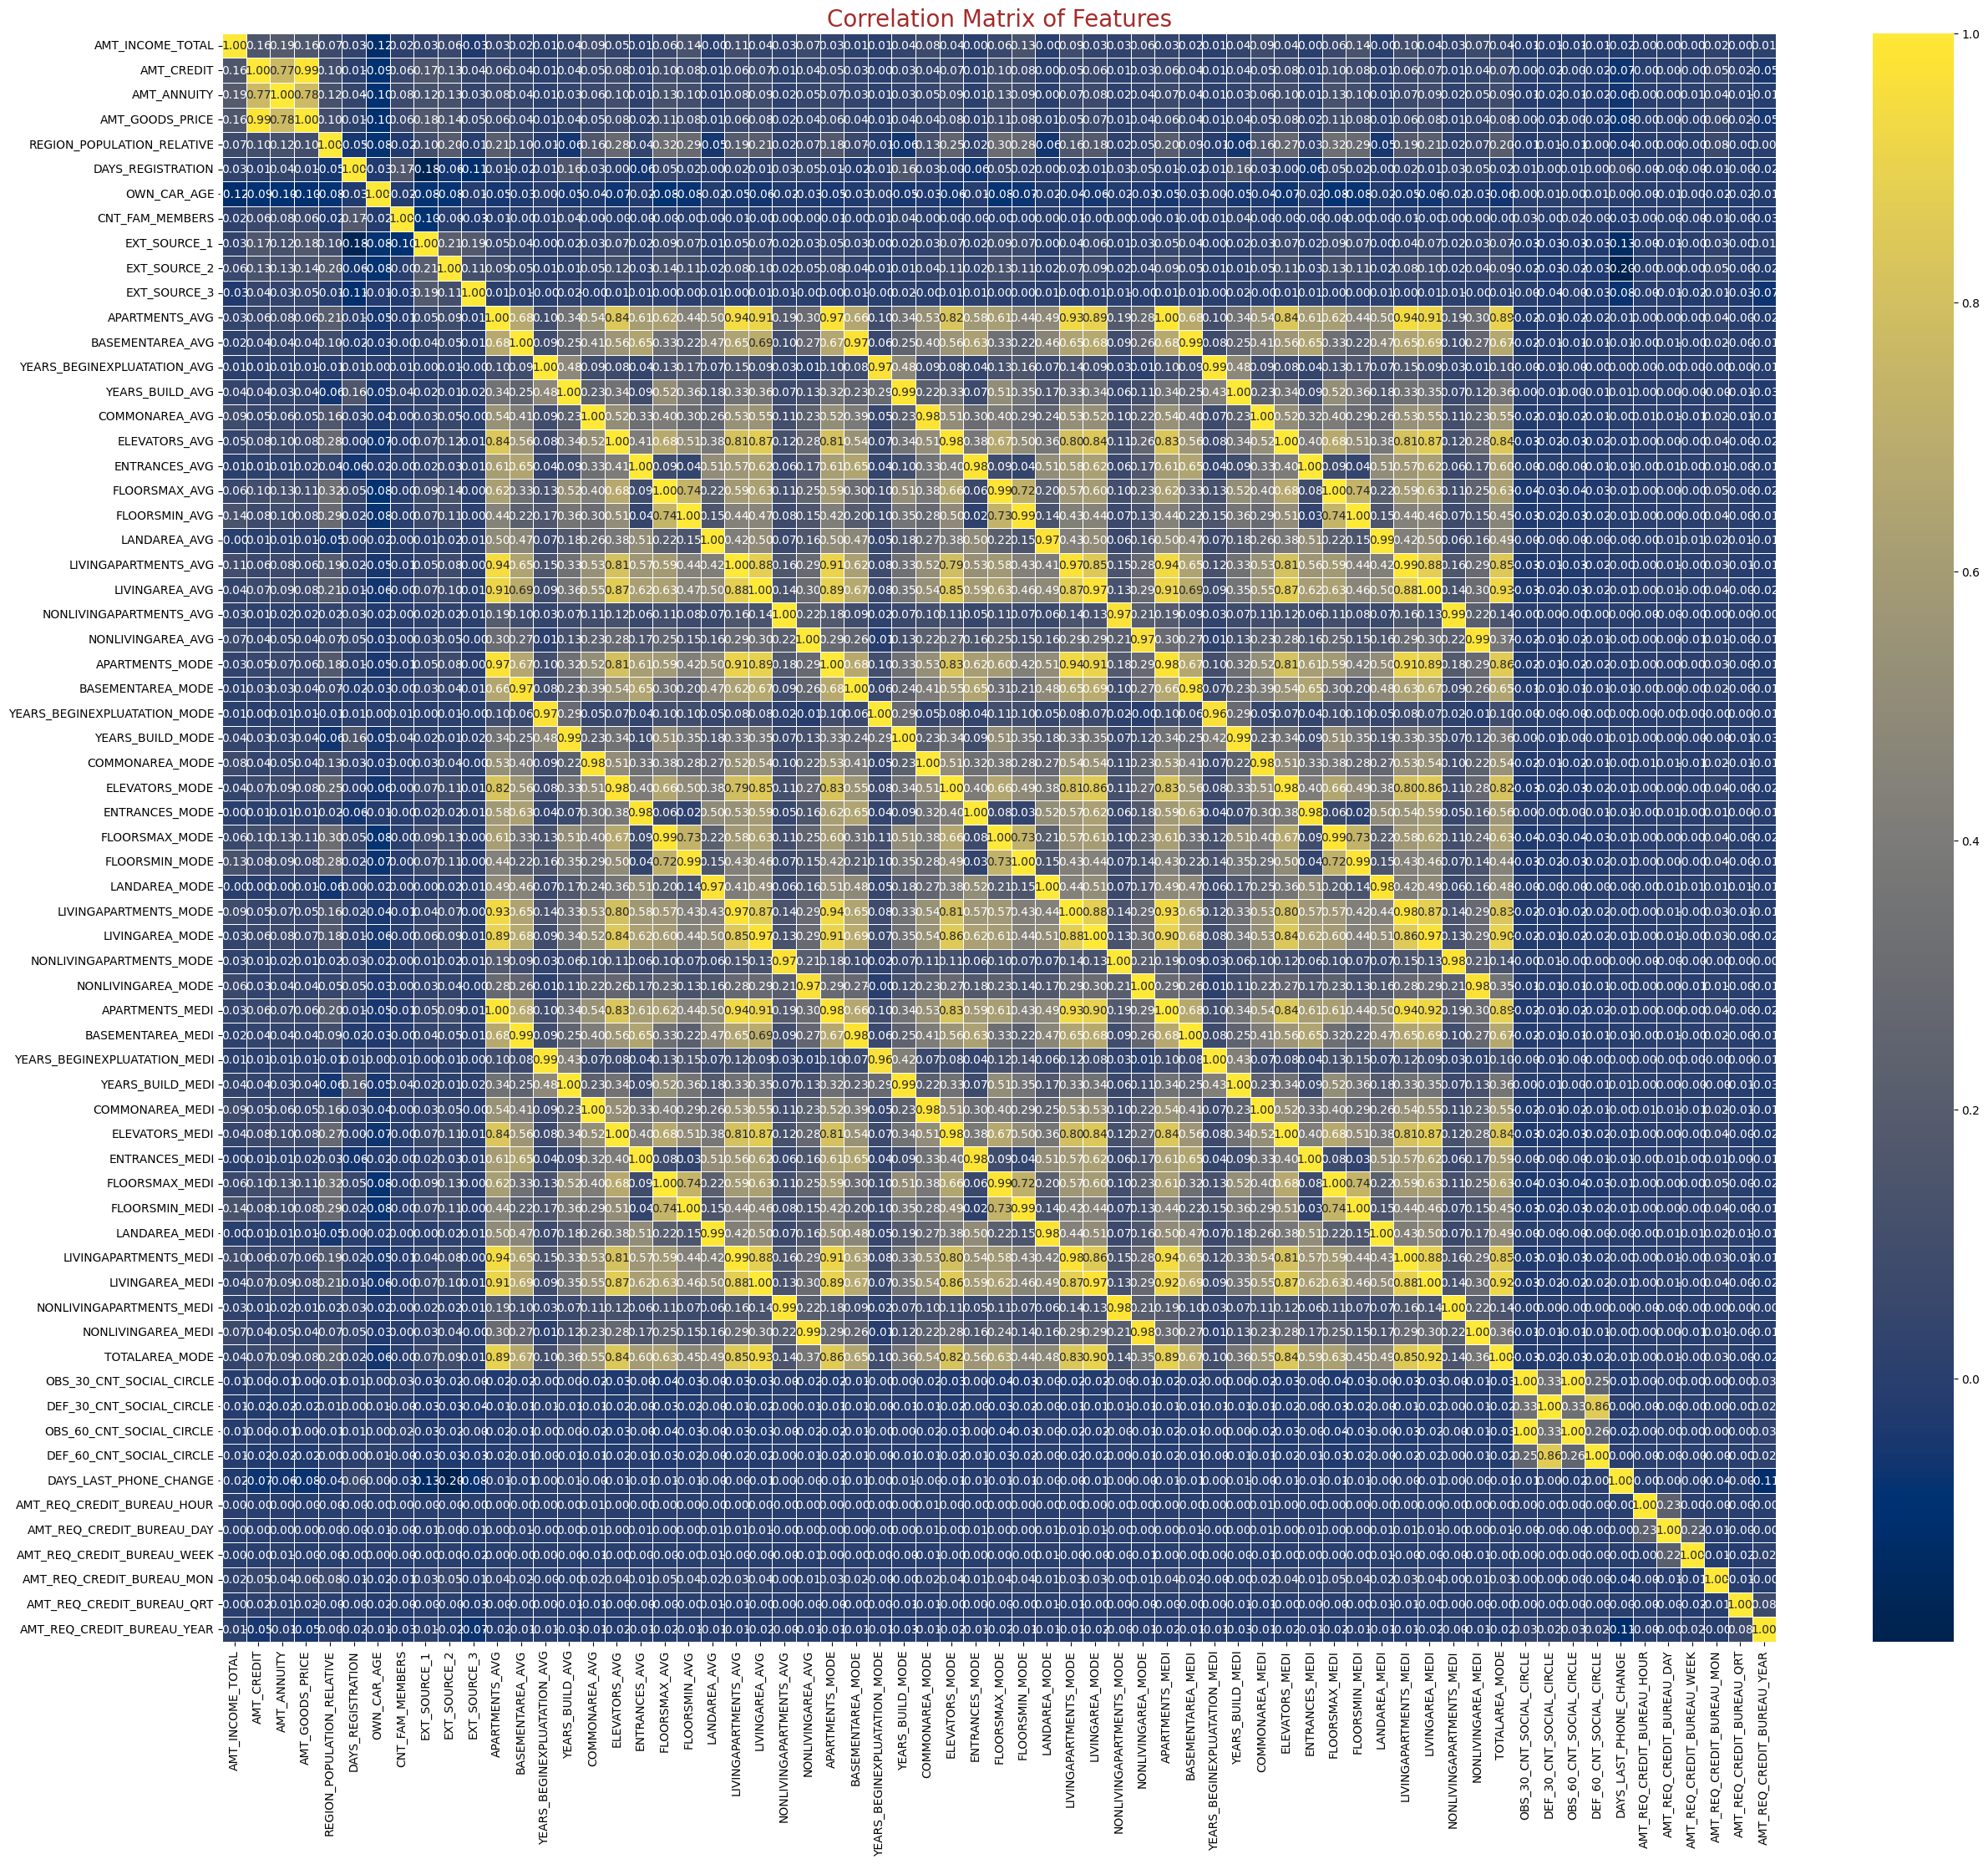

In [17]:
corr(df_corr, "cividis")

In [18]:
list(df.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

The mathemiocal distribution of the data are presented as follows: 
Mean:0.0344 
Mode:0.0 
Standard Deviation:0.2047 
Variance:0.4524


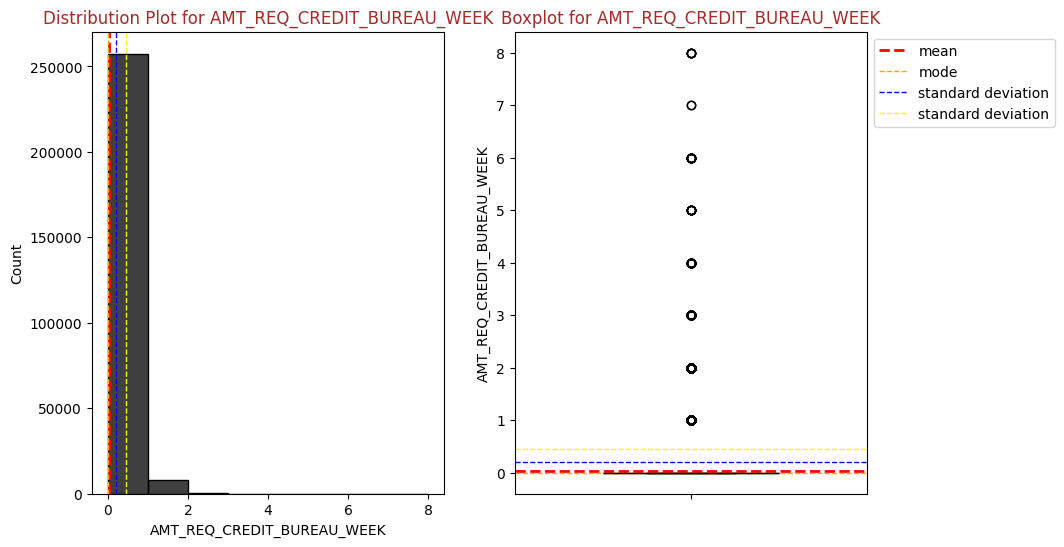

In [19]:
show_distribution(df, 'AMT_REQ_CREDIT_BUREAU_WEEK')

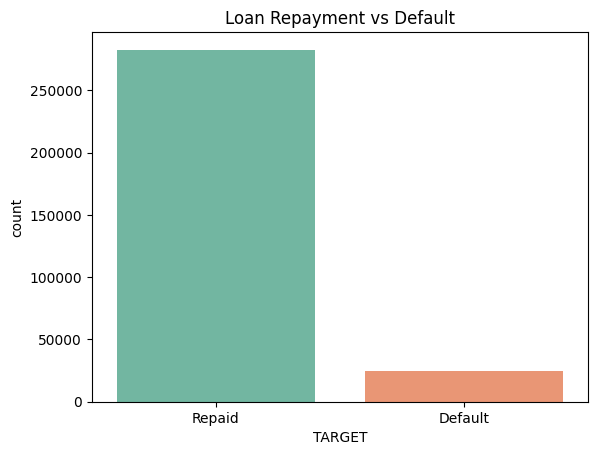

,mean,std,min,max
SK_ID_CURR,278180.518577,102790.175348,100002.00000,4.562550e+05
TARGET,0.080729,0.272419,0.00000,1.000000e+00
CNT_CHILDREN,0.417052,0.722121,0.00000,1.900000e+01
AMT_INCOME_TOTAL,168797.919297,237123.146279,25650.00000,1.170000e+08
AMT_CREDIT,599025.999706,402490.776996,45000.00000,4.050000e+06
AMT_ANNUITY,27108.573909,14493.737315,1615.50000,2.580255e+05
AMT_GOODS_PRICE,538396.207429,369446.460540,40500.00000,4.050000e+06
REGION_POPULATION_RELATIVE,0.020868,0.013831,0.00029,7.250800e-02
DAYS_BIRTH,-16036.995067,4363.988632,-25229.00000,-7.489000e+03
DAYS_EMPLOYED,63815.045904,141275.766519,-17912.00000,3.652430e+05


In [20]:
sns.countplot(x='TARGET', data=df, palette='Set2')
plt.title("Loan Repayment vs Default")
plt.xticks([0, 1], ["Repaid", "Default"])
plt.show()

df.describe().T[['mean', 'std', 'min', 'max']].head(10)

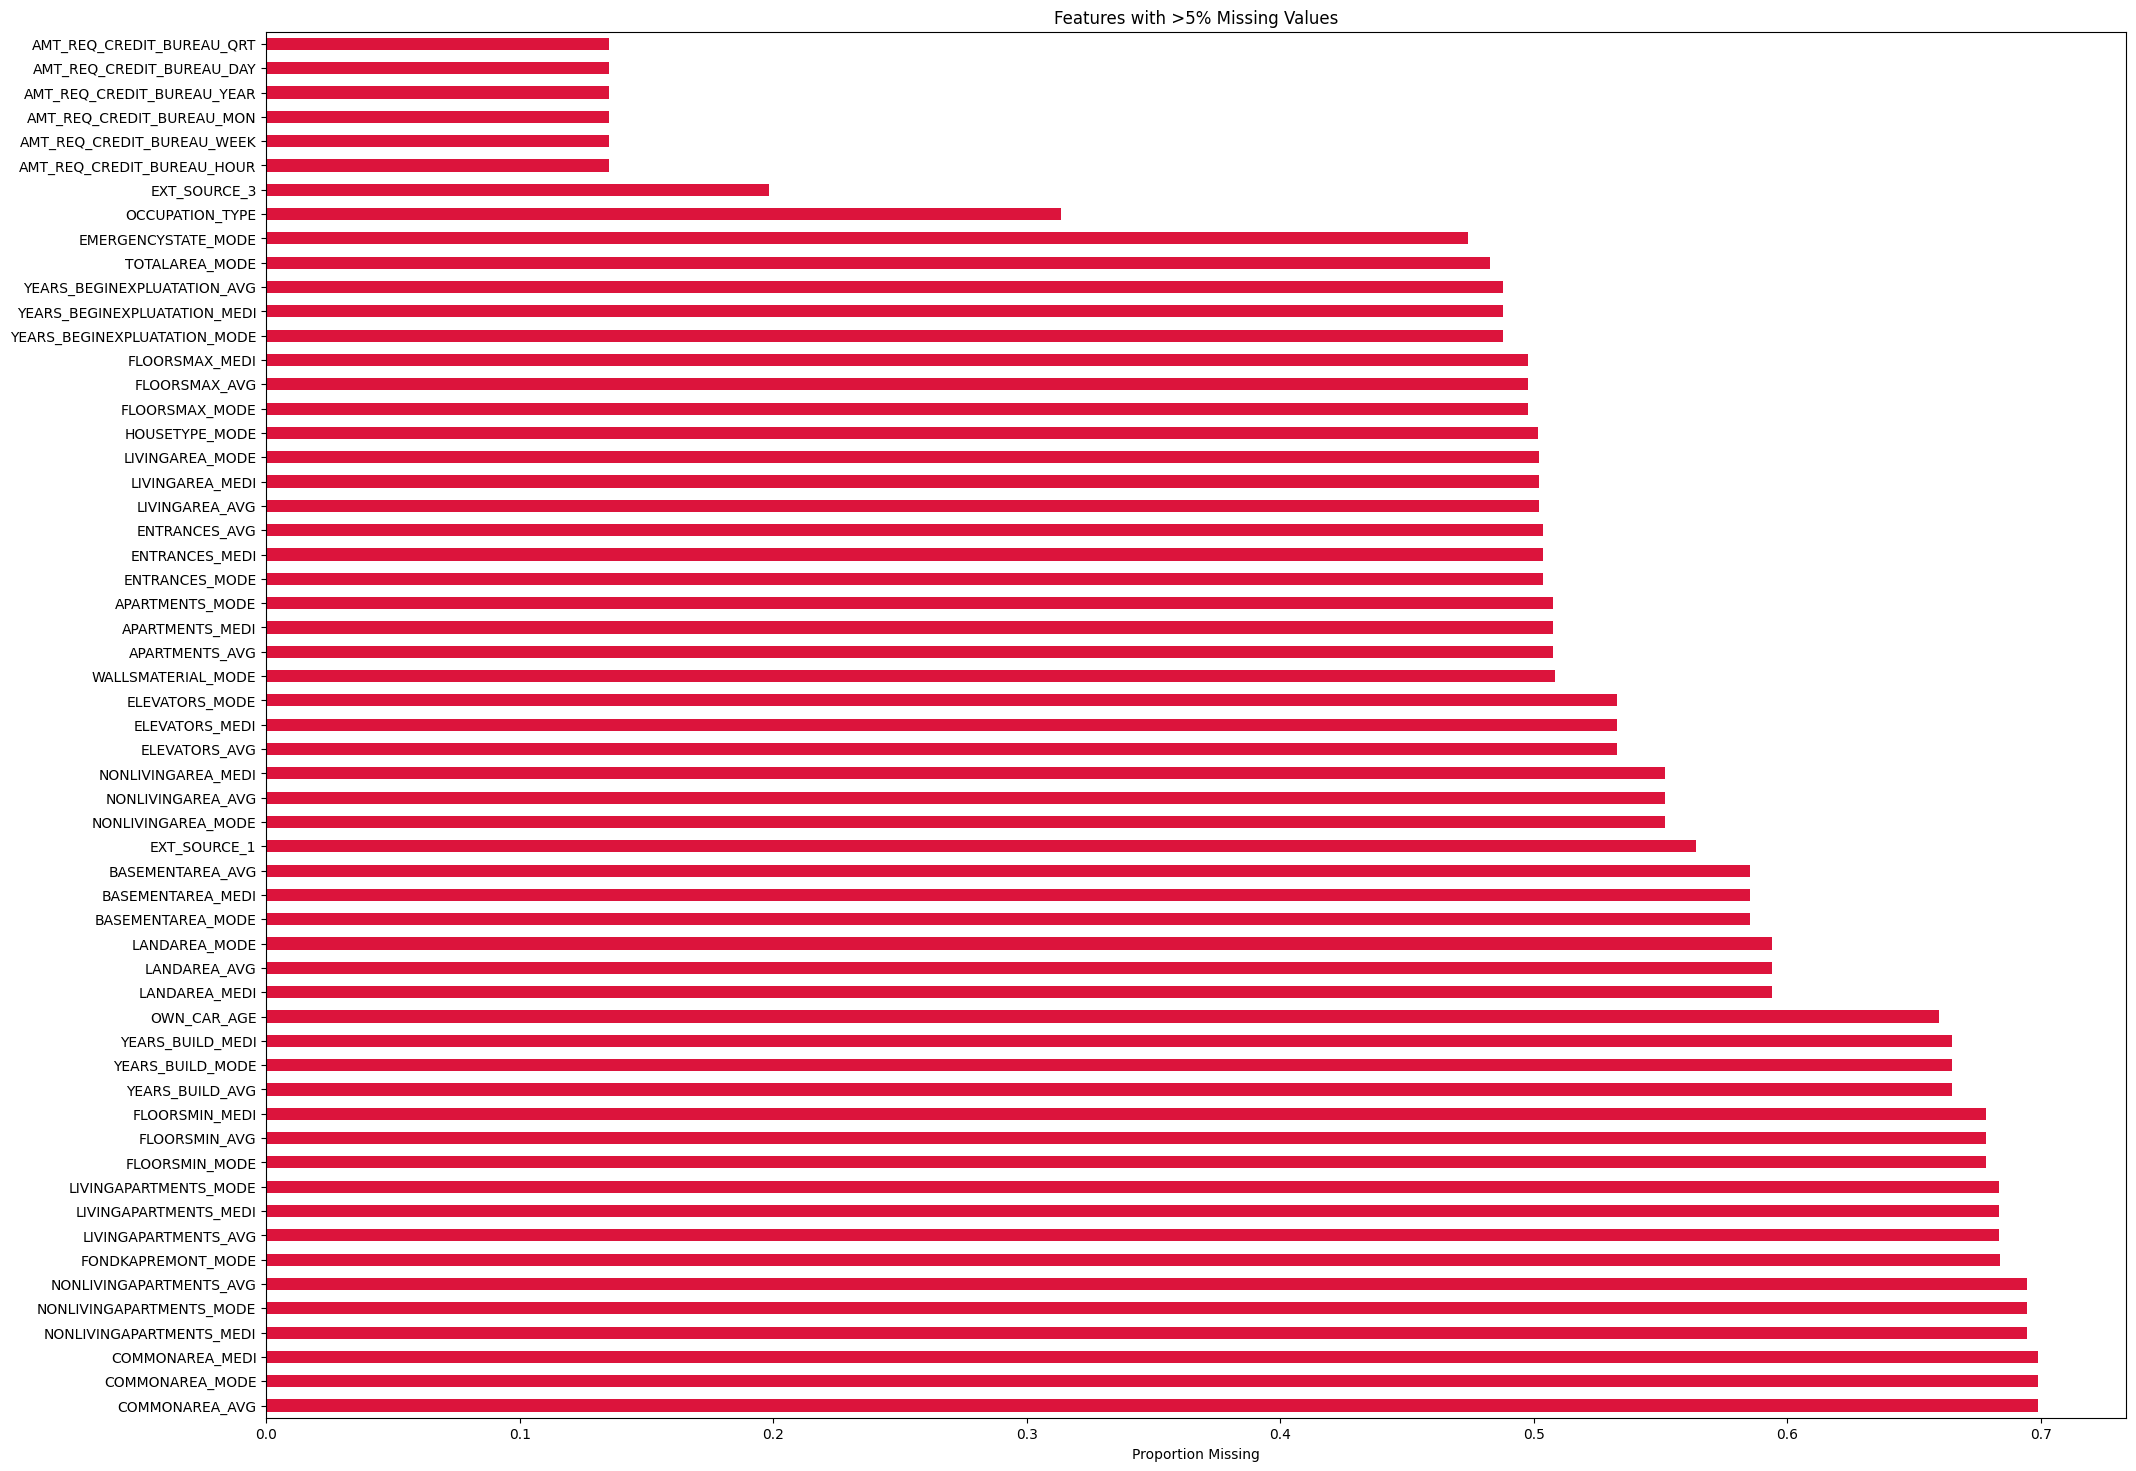

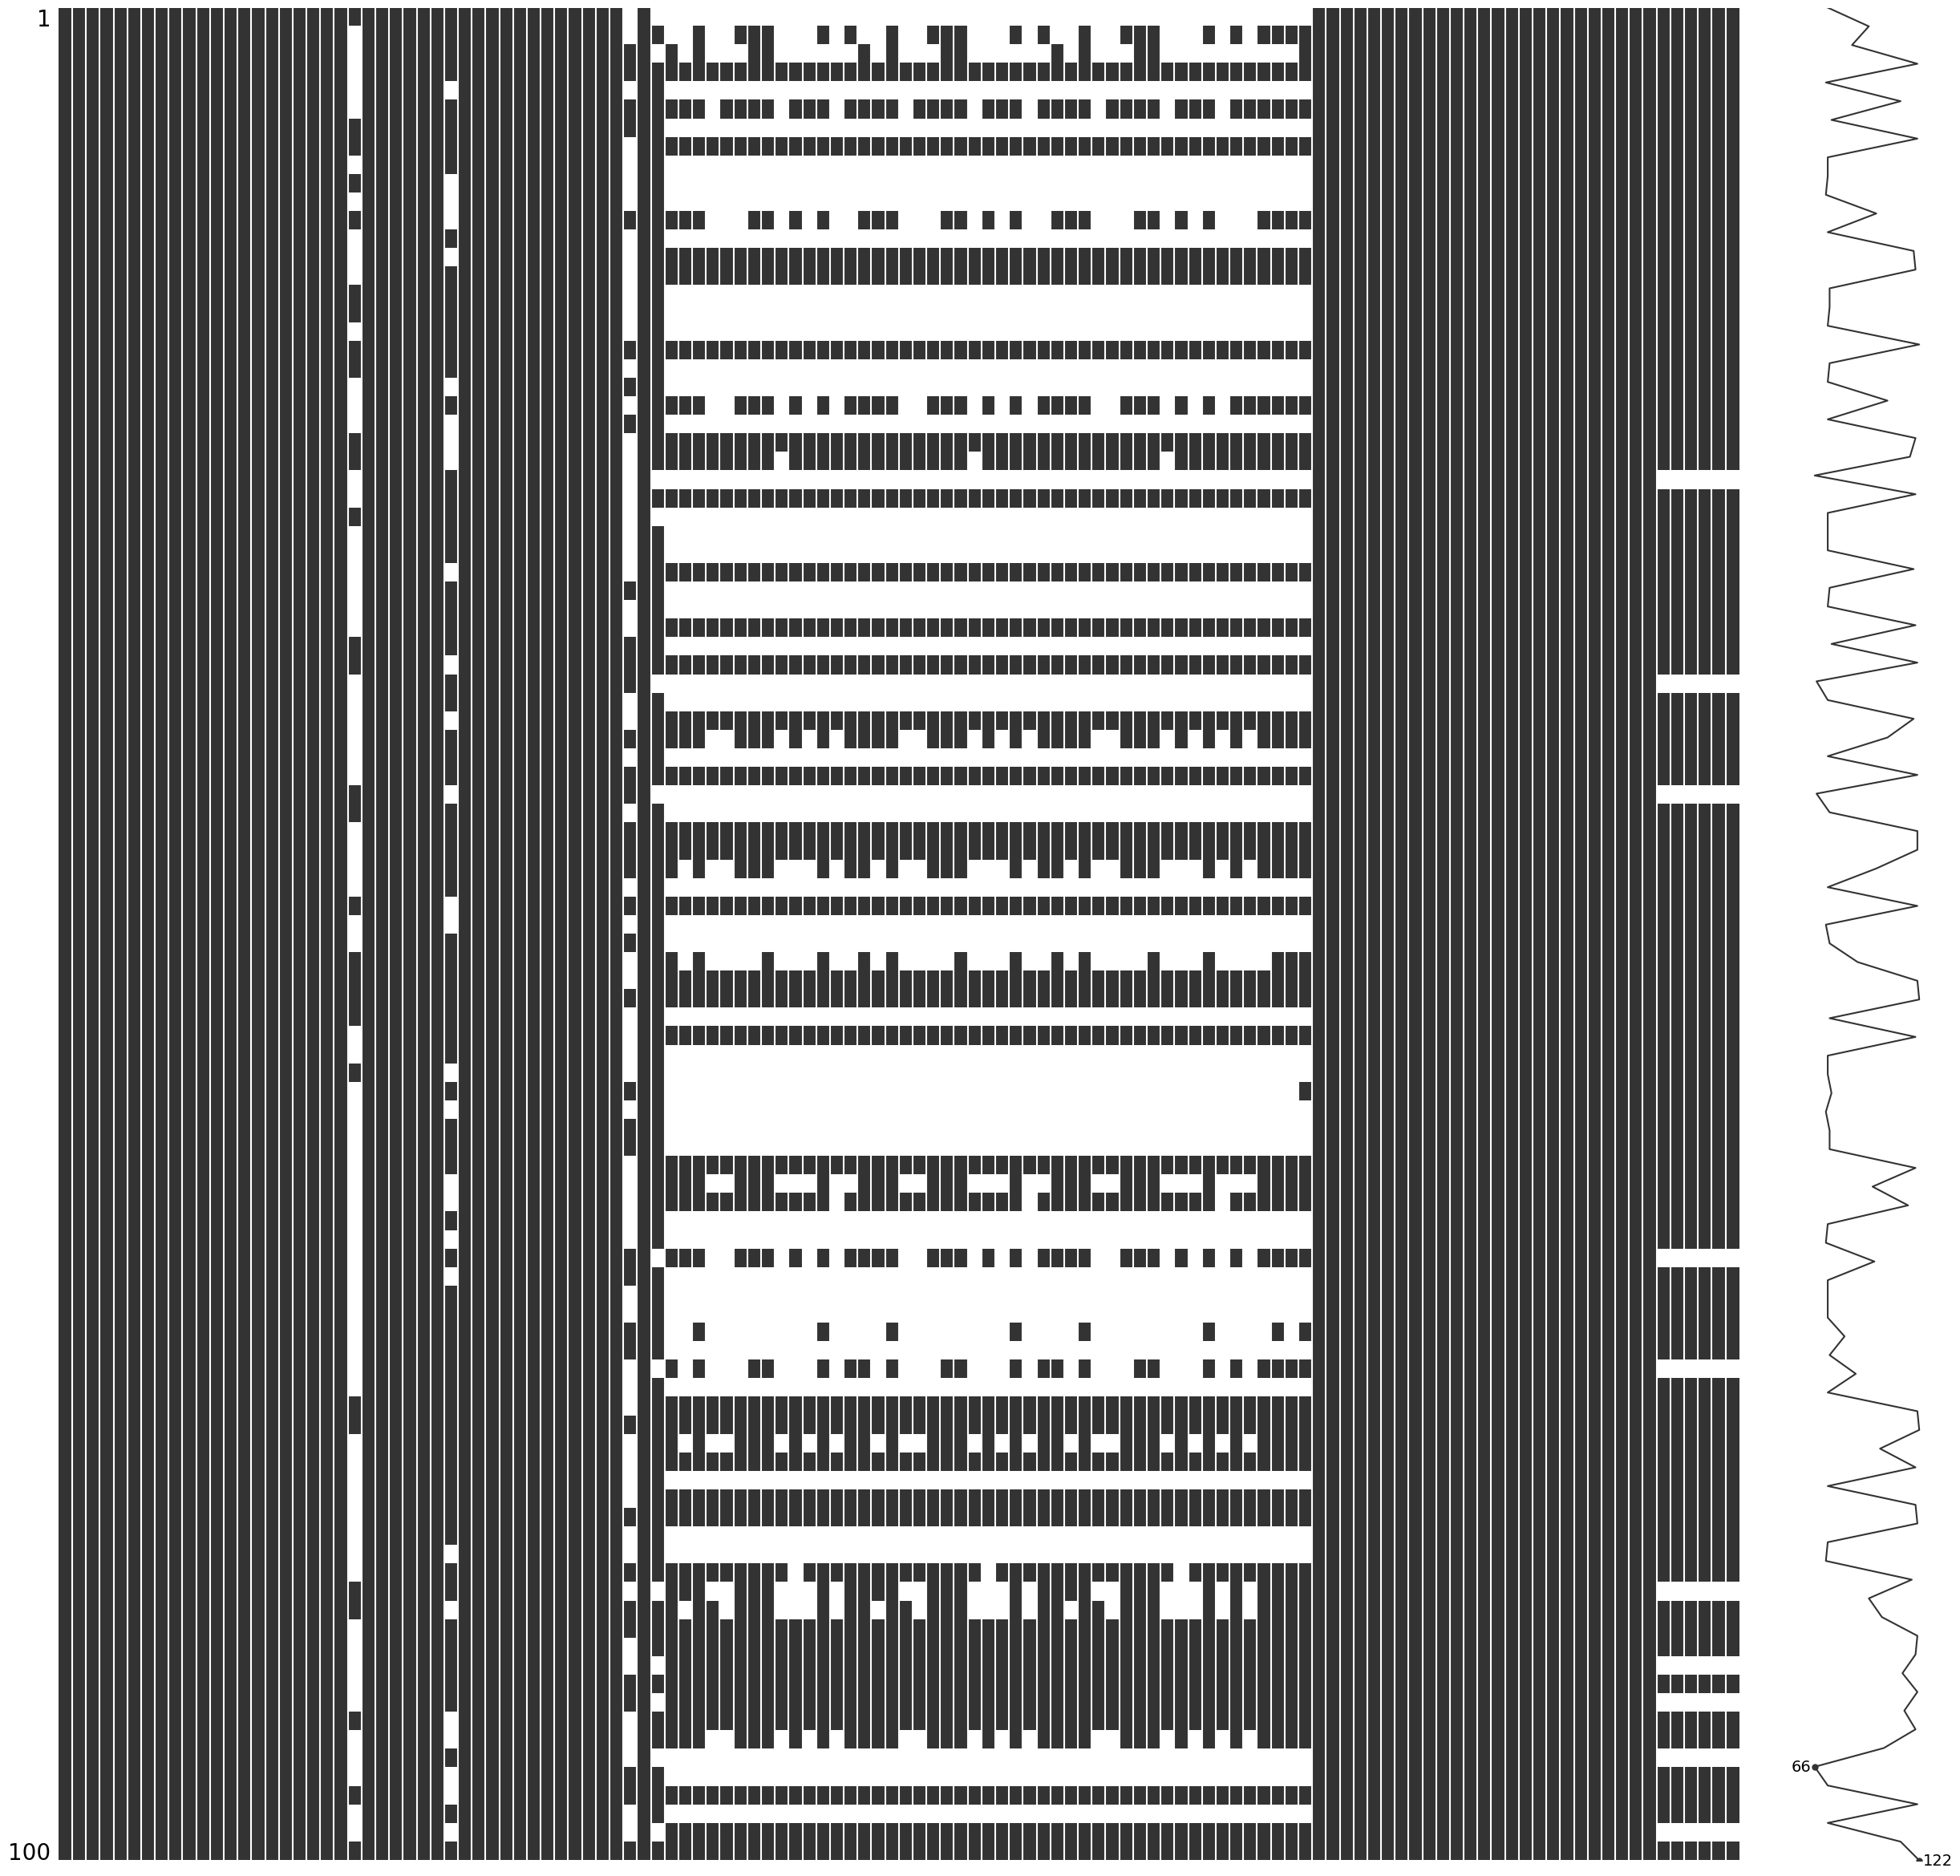

In [21]:
missing = df.isnull().mean().sort_values(ascending=False)
missing[missing > 0.05].plot(kind='barh', figsize=(24, 18), color='crimson')
plt.title("Features with >5% Missing Values")
plt.xlabel("Proportion Missing")
plt.show()

# Visual structure
msno.matrix(df.sample(100), figsize=(30, 30), color=(0.2, 0.2, 0.2))
plt.show()


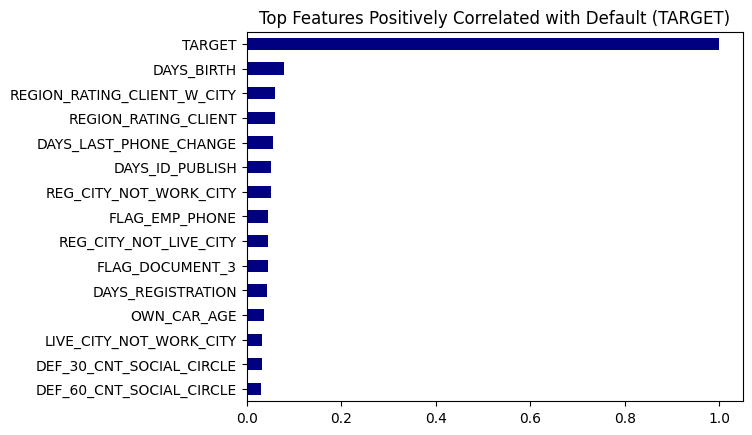

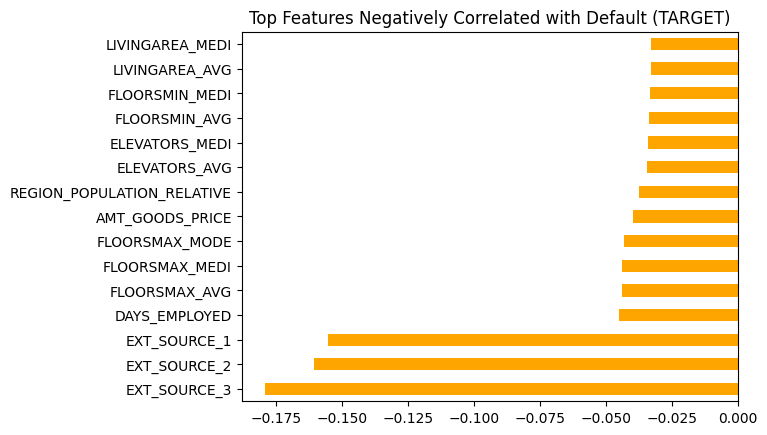

In [22]:
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()['TARGET'].sort_values()

# Top positive and negative correlations
corr.tail(15).plot(kind='barh', color='navy')
plt.title("Top Features Positively Correlated with Default (TARGET)")
plt.show()

corr.head(15).plot(kind='barh', color='orange')
plt.title("Top Features Negatively Correlated with Default (TARGET)")
plt.show()


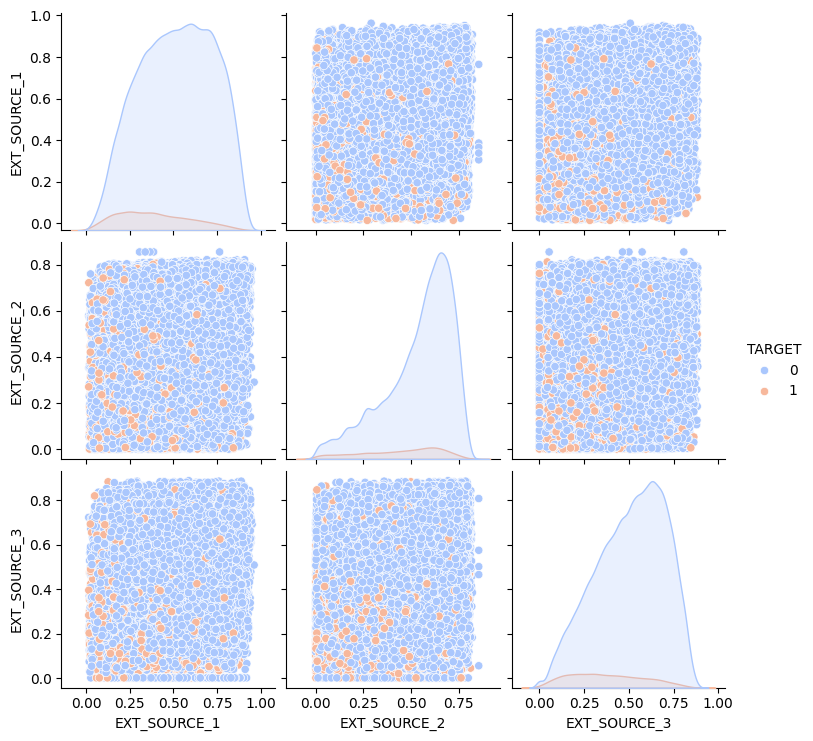

In [23]:
# EXT_SOURCEs and TARGET
ext_feats = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
sns.pairplot(df[ext_feats + ['TARGET']].dropna(), hue='TARGET', palette='coolwarm', diag_kind='kde')

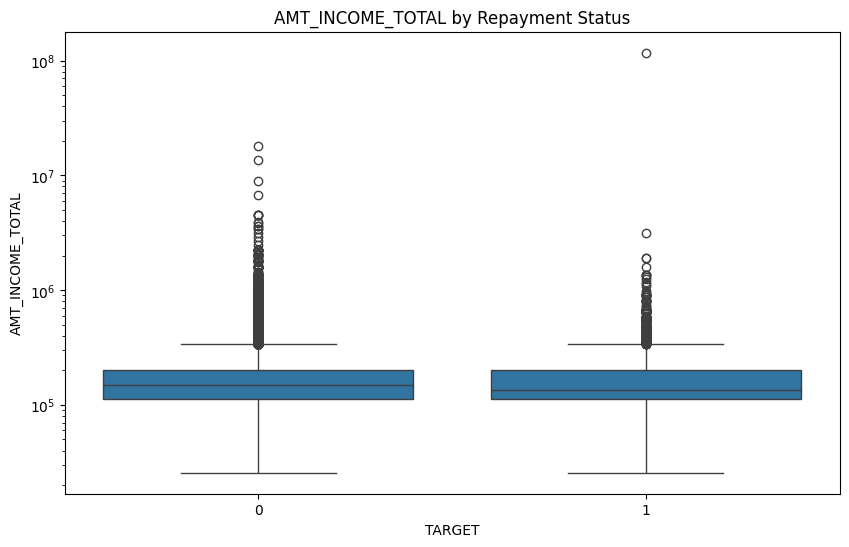

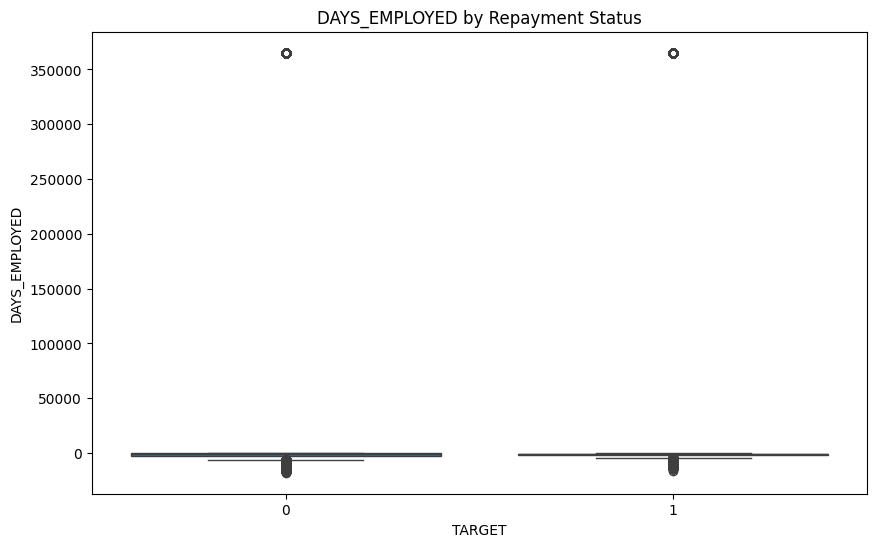

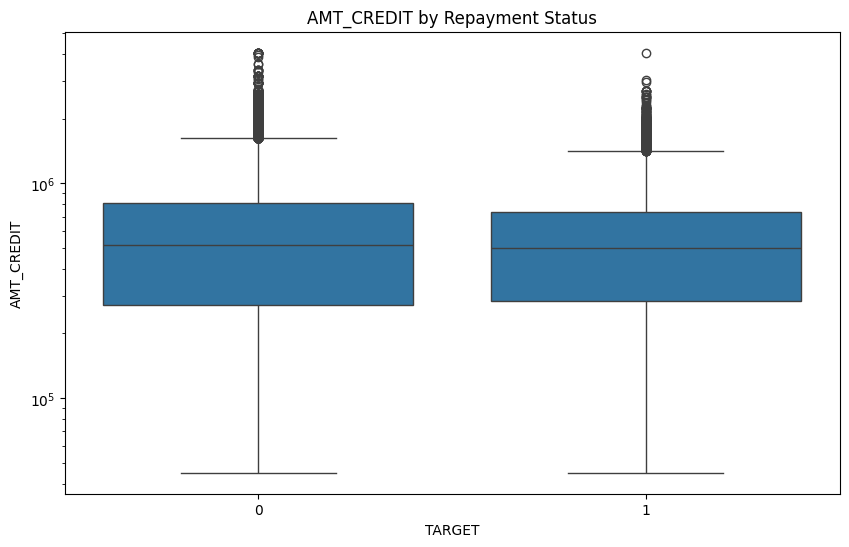

In [24]:
for col in ['AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'AMT_CREDIT']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='TARGET', y=col, data=df)
    plt.yscale('log' if col != 'DAYS_EMPLOYED' else 'linear')
    plt.title(f"{col} by Repayment Status")
    plt.show()


##  Exploratory Data Analysis Summary

- **Target Class**: ~8% of customers defaulted.
- **High Missingness** in `OWN_CAR_AGE`, `OCCUPATION_TYPE`, and `EXT_SOURCE_1`.
- **EXT_SOURCE_2/3** are very predictive of default behavior.
- **Log-scaled features** like `AMT_INCOME_TOTAL` show better separation visually.
- **Outliers** detected in income and credit — consider capping or transformations.


>## 3. Modeling

This section details the model building process, including data splitting, model selection, cross-validation, and performance evaluation.

>### Data Splitting

The dataset was split into training and testing sets to evaluate model performance on unseen data. `SK_ID_CURR` was dropped as it's an identifier, and `TARGET` was set as the dependent variable `y`.
* The data was split using `train_test_split` with a `test_size` of 0.2 (20% for testing)].
* To maintain the proportion of `TARGET` classes in both training and testing sets due to class imbalance, `stratify=y` was used.
* A `random_state` of 42 was set for reproducibility.

In [25]:
df_fe = df.copy()

# Dropping columns with too much missing
drop_cols = df_fe.columns[df_fe.isnull().mean() > 0.5]
print("Dropping columns with >50% missing:", list(drop_cols))
df_fe.drop(columns=drop_cols, inplace=True)

# Categorical: Fill missing with 'Unknown'
cat_cols = df_fe.select_dtypes(include='object').columns
df_fe[cat_cols] = df_fe[cat_cols].fillna("Unknown")

# Numerical: Use KNN Imputer for remaining
num_cols = df_fe.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='mean')
df_fe[num_cols] = imputer.fit_transform(df_fe[num_cols])


Dropping columns with >50% missing: ['OWN_CAR_AGE', 'EXT_SOURCE_1', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']


In [26]:
# Credit-to-Income Ratio
df_fe['CREDIT_INCOME_RATIO'] = df_fe['AMT_CREDIT'] / (df_fe['AMT_INCOME_TOTAL'] + 1)

# Annuity-to-Income Ratio
df_fe['ANNUITY_INCOME_RATIO'] = df_fe['AMT_ANNUITY'] / (df_fe['AMT_INCOME_TOTAL'] + 1)

# Employment Stability (positive values since DAYS_EMPLOYED is negative)
df_fe['EMPLOYMENT_AGE_RATIO'] = -df_fe['DAYS_EMPLOYED'] / (-df_fe['DAYS_BIRTH'] + 1)

# Children Load
df_fe['CHILDREN_RATIO'] = df_fe['CNT_CHILDREN'] / (df_fe['CNT_FAM_MEMBERS'] + 1)


In [27]:
cat_cols = df_fe.select_dtypes(include='object').columns

# Threshold: one-hot if <=10 categories, else label encode
low_card_cols = [col for col in cat_cols if df_fe[col].nunique() <= 10]
high_card_cols = [col for col in cat_cols if df_fe[col].nunique() > 10]

# One-hot encode for featuress with low-cardinality
df_fe = pd.get_dummies(df_fe, columns=low_card_cols, drop_first=True)

# Label encode for features with high-cardinality (for XGBoost compatibility)
le = LabelEncoder()
for col in high_card_cols:
    df_fe[col] = le.fit_transform(df_fe[col])


In [28]:
print("Final shape after feature engineering:", df_fe.shape)
print("Remaining nulls:", df_fe.isnull().sum().sum())


Final shape after feature engineering: (307511, 115)
Remaining nulls: 0


In [29]:
df_fe.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,EMPLOYMENT_AGE_RATIO,CHILDREN_RATIO,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_Unknown,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,EMERGENCYSTATE_MODE_Unknown,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,-3648.0,-2120.0,1.0,1.0,0.0,1.0,1.0,0.0,8,1.0,2.0,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0.262949,0.139376,0.972200,0.083300,0.972200,0.083300,0.972200,0.083300,0.014900,2.0,2.0,2.0,2.0,-1134.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,1.000000,2.007879,0.121977,0.067322,0.0,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
1,100003.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,-1186.0,-291.0,1.0,1.0,0.0,1.0,1.0,0.0,3,2.0,1.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,39,0.622246,0.510853,0.985100,0.291700,0.985100,0.291700,0.985100,0.291700,0.071400,1.0,0.0,1.0,0.0,-828.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,4.790732,0.132216,0.070858,0.0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False
2,100004.0,0.0,0.0,6750

### Feature Engineering Summary

-  **Missingness**:
  - Strategic: dropped high-null features, imputed remaining via KNN & median
- **New Features**:
  - `CREDIT_INCOME_RATIO`, `ANNUITY_INCOME_RATIO`, `EMPLOYMENT_AGE_RATIO`, and `EXT_SOURCE` aggregations designed to capture structural and behavioral risk
-  **Encoding**:
  - Used **hybrid encoding**: One-hot for interpretable features and LabelEncoder for higher cardinality, optimizing for model input quality
- Dataset is now fully numerical, clean, and enriched with signal-bearing features


## 3. Model Training and Comparison

Four different machine learning models were selected for comparison, representing various algorithmic approaches:
* **Logistic Regression:** A linear model with `class_weight='balanced'` and `solver='liblinear'` to address class imbalance and ensure convergence.
* **Random Forest Classifier:** An ensemble tree-based model with `n_estimators=200` and `max_depth=10`, also using `class_weight='balanced'`.
* **XGBoost Classifier (`XGBClassifier`):** A gradient boosting framework with `n_estimators=300`, `max_depth=6`, and `learning_rate=0.05`. Class imbalance was handled by `scale_pos_weight`, and `eval_metric='logloss'` was specified.
* **CatBoost Classifier (`CatBoostClassifier`):** Another gradient boosting framework, configured with `iterations=300`, `depth=6`, `learning_rate=0.05`, and `auto_class_weights='Balanced'` to manage imbalance.


In [30]:
X = df_fe.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_fe['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42
    )

>### Cross-Validation and Metric Performance

**Cross-Validation:**
To obtain a robust estimate of model performance and reduce variance, `StratifiedKFold` cross-validation was used with 5 splits (`n_splits=5`), shuffling enabled (`shuffle=True`), and a `random_state` of 42.

**Performance Metric:**
The **ROC AUC (Receiver Operating Characteristic Area Under the Curve)** was chosen as the primary evaluation metric. ROC AUC is particularly suitable for imbalanced datasets as it measures the classifier's ability to distinguish between classes across all possible classification thresholds.

**Results:**
The mean ROC AUC scores from the cross-validation for each model were as follows:
* **Logistic Regression:** 0.6693 $\pm$ 0.0034
* **Random Forest:** 0.7294 $\pm$ 0.0020
* **XGBoost:** 0.7487 $\pm$ 0.0018
* **CatBoost:** 0.7505 $\pm$ 0.0016

In [33]:
import pickle

models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        class_weight='balanced',
        random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
        use_label_encoder=False, eval_metric='logloss',
        random_state=42),
    "CatBoost": CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.05,
        verbose=0,
        auto_class_weights='Balanced',
        random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, model in models.items():
    print(f"\n🔍 {name}")
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"ROC AUC: {scores.mean():.4f} ± {scores.std():.4f}")
    pickle.dump(model, open(f'{name}.pkl', 'wb'))



🔍 Logistic Regression
ROC AUC: 0.6693 ± 0.0134

🔍 Random Forest
ROC AUC: 0.7294 ± 0.0020

🔍 XGBoost
ROC AUC: 0.7487 ± 0.0018

🔍 CatBoost
ROC AUC: 0.7505 ± 0.0016


`CatBoost` and `XGBoost` significantly outperformed Logistic Regression and Random Forest, with `CatBoost` showing a slight edge. The small standard deviations indicate good stability across the folds. A bar plot visually compared the mean ROC AUC scores of the models

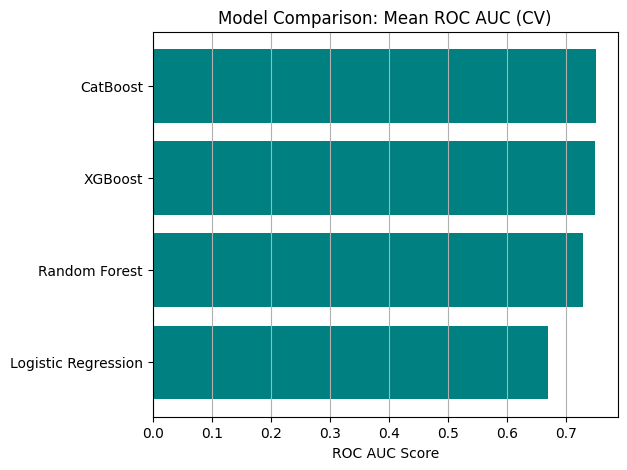

In [34]:
# Visual comparison
plt.figure(figsize=(6, 5))
model_names = list(results.keys())
roc_means = [np.mean(scores) for scores in results.values()]
plt.barh(model_names, roc_means, color='teal')
plt.title("Model Comparison: Mean ROC AUC (CV)")
plt.xlabel("ROC AUC Score")
plt.grid(True, axis='x')
plt.show()


## 4. Model Interpretation

Model interpretability is crucial for understanding why a model makes certain predictions and for gaining insights into the underlying drivers of customer default risk. `SHAP` (`SHapley Additive exPlanations`) was used to explain the predictions of the best-performing XGBoost model.

### Understanding SHAP Values

SHAP values quantify the contribution of each feature to the prediction for a specific instance, showing whether a feature's presence increases or decreases the prediction compared to the baseline. In the context of the summary plot, it illustrates the impact of features across the entire dataset.

>### Analysis of SHAP Summary Plot

>### Top Predictive Features and Their Relevance

Based on the SHAP summary plot, the most impactful features for predicting loan default are:

1.  **`EXT_SOURCE_3`:**
    * **Impact:** This is the most significant feature. Higher values (red dots, indicating higher `EXT_SOURCE_3` scores) predominantly have negative SHAP values, pushing the prediction towards **repayment (non-default)**. Conversely, lower `EXT_SOURCE_3` values (blue dots) lead to positive SHAP values, strongly indicating **default**. A higher `EXT_SOURCE_3` score might  suggests a lower risk of default. Loan funding decisions could strongly favor applicants with high `EXT_SOURCE_3` values. This external data source is  capturing crucial information about an applicant's creditworthiness or stability.

2.  **`EXT_SOURCE_2`:**
    * **Impact:** Similar to `EXT_SOURCE_3`, higher values of `EXT_SOURCE_2` (red dots) are associated with negative SHAP values, contributing to a **repayment** prediction. Lower values (blue dots) have positive SHAP values, increasing the likelihood of **default**.
    * **Relevance to Loan Funding:** `EXT_SOURCE_2` is also a critical indicator of risk. Applicants with lower `EXT_SOURCE_2` scores pose a higher risk, and caution should be exercised when considering their applications. Higher scores here might imply greater reliability.

3.  **`CODE_GENDER_M`:**
    * **Impact:** A one-hot encoded feature for 'Male' gender. If `CODE_GENDER_M` is 1 (red dots, male), it generally has positive SHAP values, suggesting that **male applicants are associated with a higher likelihood of default**. If 0 (blue dots, female), it has negative SHAP values, indicating a lower default probability.
    * **Relevance to Loan Funding:** This suggests a gender-based risk differential, with male applicants showing a slightly higher propensity for default in this dataset. This insight could inform risk assessment models, but it's important to consider ethical implications and avoid discriminatory practices.

4.  **`AMT_GOODS_PRICE`:**
    * **Impact:** Higher `AMT_GOODS_PRICE` (red dots) tends to have slightly negative SHAP values, nudging towards **repayment**. Lower `AMT_GOODS_PRICE` (blue dots) has positive SHAP values, increasing the risk of **default**.
    * **Relevance to Loan Funding:** Applicants seeking loans for lower-priced goods might be riskier. This could be because lower loan amounts are sought by individuals with more constrained financial situations, or perhaps these loans are for less essential items, indicating different financial priorities.

5.  **`DAYS_BIRTH`:**
   This might seem to be counterintuitive if we assume older people are more financially stable; however, the data suggests otherwise or there's a non-linear relationship.
    * **Relevance to Loan Funding:** Age appears to play a complex role. Younger applicants (less negative `DAYS_BIRTH`) may be slightly less prone to default based on this model's interpretation, which is interesting and warrants further investigation.

Other features like `NAME_EDUCATION_TYPE_Higher education`, `DAYS_EMPLOYED`, `AMT_CREDIT`, `FLAG_OWN_CAR_Y`, `FLAG_DOCUMENT_3`, `NAME_INCOME_TYPE_Working`, `DAYS_ID_PUBLISH`, `AMT_ANNUITY`, `NAME_CONTRACT_TYPE_Revolving loans`, `NAME_FAMILY_STATUS_Married`, `DAYS_LAST_PHONE_CHANGE`, `EMPLOYMENT_AGE_RATIO`, `ANNUITY_INCOME_RATIO`, `REGION_RATING_CLIENT_W_CITY`, and `NAME_EDUCATION_TYPE_Secondary / secondary special` also contribute to the prediction but to a lesser extent, with their positive or negative impact depending on their values as shown.


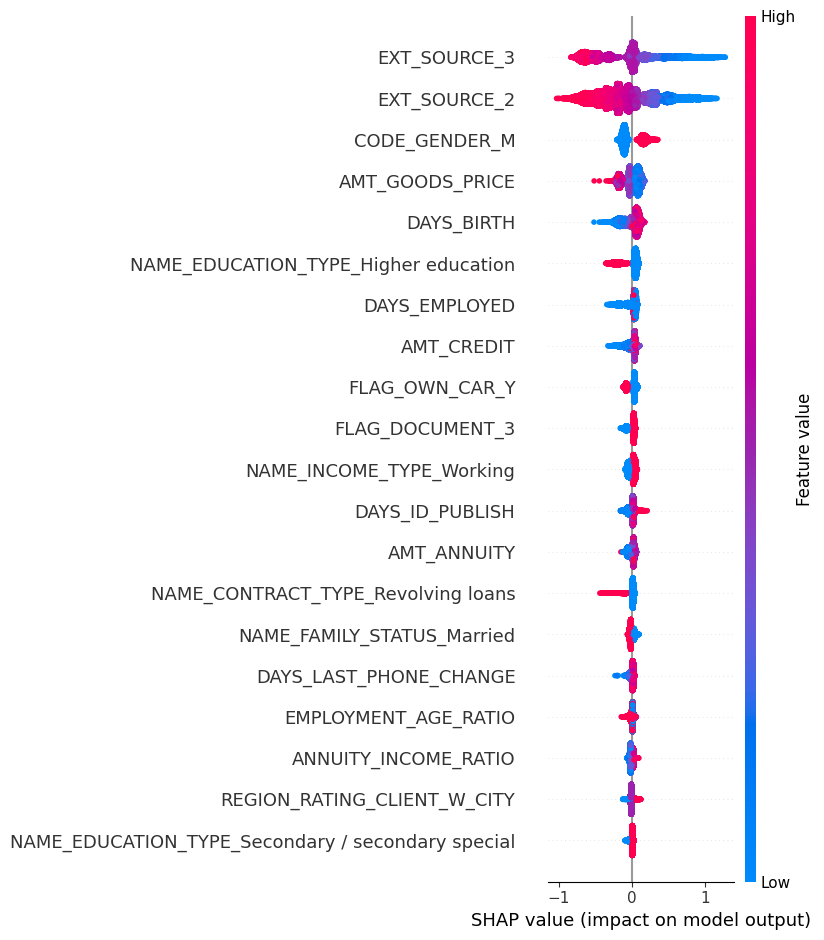

In [35]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Use safe SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)


---
># 5. Business Actionables Based on Model Insights
---

Based on the EDA and SHAP interpretations, here are concrete business actionables to improve loan funding decisions:

1.  **Prioritize Applicants with Strong External Scores:** Given the high predictive power of `EXT_SOURCE_2` and `EXT_SOURCE_3`, develop a robust system to integrate and heavily weigh these external credit scores in the application process. Applicants with demonstrably higher scores on these features should be fast-tracked or offered more favorable terms, as they are significantly less likely to default.
2.  **Cautious Approach for Low `EXT_SOURCE` Applicants:** For applicants with low `EXT_SOURCE_2` or `EXT_SOURCE_3` values, consider stricter scrutiny, higher collateral requirements, or potentially offer smaller loan amounts initially.
3.  **Refine Risk Assessment for Demographic Groups:** Acknowledge the observed difference in default rates based on `CODE_GENDER`. While not a basis for discrimination, this insight could prompt a review of marketing strategies or product offerings to ensure they are appropriately tailored to different demographic segments, or to identify other underlying factors contributing to this disparity.
4.  **Evaluate Loan Purpose/Amount Correlation:** Further investigation on why loans for lower `AMT_GOODS_PRICE` appear to be associated with higher default risk. This could lead to adjusted risk profiling for different loan purposes or amounts, potentially requiring more rigorous checks for smaller loans.
5.  **Re-evaluate Age-Related Risk:** The `DAYS_BIRTH` insight, suggesting younger applicants (less negative days) are less prone to default, challenges conventional wisdom. This warrants deeper analysis to understand the specific demographic segments or life stages that might be driving this observation. It could inform targeted product development or risk adjustments for different age groups.
6.  **Leverage New Features:** The engineered features like `CREDIT_INCOME_RATIO`, `ANNUITY_INCOME_RATIO`, and `EMPLOYMENT_AGE_RATIO` have enriched the dataset's predictive signal. Ensure these ratios are calculated and utilized in real-time application assessments, potentially setting thresholds for approval or flagging high-risk cases.

---
>### Executive Summary of Predicting Financing Risks
---

The objective of predicting customer asset financing risk was successfully addressed through a structured machine learning pipeline. Initial exploratory data analysis highlighted the dataset's characteristics, including a significant class imbalance (8% default rate) and the critical importance of external data sources for predicting default.

A comprehensive feature engineering process effectively handled missing values by selective dropping and imputation, while simultaneously creating new, insightful features like `CREDIT_INCOME_RATIO` and `EMPLOYMENT_AGE_RATIO`. Categorical variables were judiciously encoded using a hybrid approach to prepare the data for diverse modeling techniques.

Four models (Logistic Regression, Random Forest, XGBoost, and CatBoost) were evaluated using stratified cross-validation and ROC AUC as the primary metric. The gradient boosting models, particularly CatBoost (ROC AUC: 0.7505) and XGBoost (ROC AUC: 0.7487), demonstrated superior performance in distinguishing between loan repayers and defaulters, showcasing their ability to capture complex non-linear relationships within the data. Class imbalance was effectively managed in all models through appropriate weighting strategies.

Finally, model interpretability using SHAP values provided transparent insights into the most influential features. `EXT_SOURCE_3` and `EXT_SOURCE_2` were identified as overwhelmingly important predictors, indicating that external creditworthiness assessments are paramount. Other features like gender, goods price, and age also played a role. These insights empower the business to make data-driven decisions by prioritizing low-risk applicants based on these key features and implementing more stringent checks for high-risk profiles, thereby optimizing loan funding strategies and mitigating default risk.






